In [ ]:
import copy
import time
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np
import optax
from matplotlib import pyplot as plt
from rich.console import Console, Group
from rich.layout import Layout
from rich.live import Live
from rich.panel import Panel
from rich.progress import (
    BarColumn,
    Progress,
    TaskProgressColumn,
    TextColumn,
    TimeRemainingColumn,
)
from tqdm.rich import tqdm

from vkplatejax.excitations import create_pluck_modal
from vkplatejax.ftm import (
    StringParameters,
    eigenvalues_from_pde,
    forward_STL,
    inverse_STL,
    string_eigenfunctions,
    string_eigenvalues,
    tf_freqs,
    tf_initial_conditions_continuous_2,
)
from vkplatejax.losses import (
    batched_spectral_wasserstein,
    log_mag,
    log_mag_loss,
    spectral_convergence_loss,
    spectral_wasserstein,
)


In [20]:
string_params = StringParameters()

(32,)
(32, 101)
(101,)


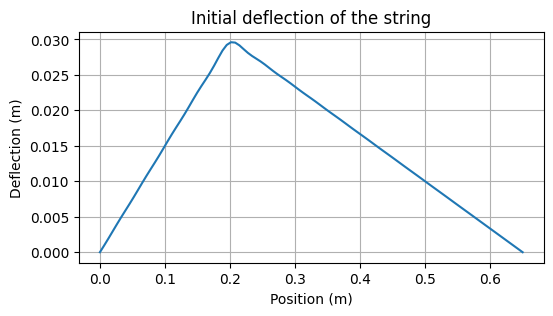

In [21]:
n_modes = 32

lambda_mu = string_eigenvalues(n_modes, string_params.length)
grid = np.linspace(0, string_params.length, 101)
K = string_eigenfunctions(jnp.sqrt(lambda_mu), grid)

dx = grid[1] - grid[0]

z0 = create_pluck_modal(
    lambda_mu,
    pluck_position=0.2,
    initial_deflection=0.03,
    string_length=string_params.length,
)
print(z0.shape)
print(K.shape)
u0 = inverse_STL(K, z0, string_params.length)

print(u0.shape)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(grid, u0)
ax.set_xlabel("Position (m)")
ax.set_ylabel("Deflection (m)")
ax.set_title("Initial deflection of the string")
ax.grid(True)
# print(y0.shape)

(32, 1000)
(32, 2) (32, 3)


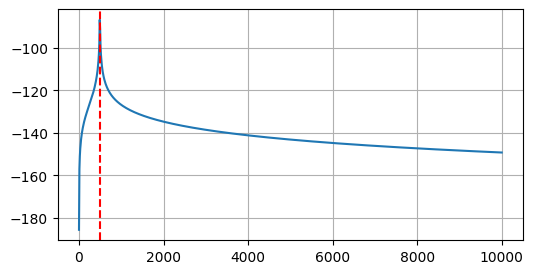

In [22]:
# omegas = jnp.arange(0, 10_000)  # in Hz
omegas = jnp.linspace(0, 10_000, 1000)
s = 2j * jnp.pi * omegas

mode_index = 1
eigvals = eigenvalues_from_pde(
    pars=string_params,
    lambda_mu=lambda_mu,
)
exact_freq = eigvals.imag[mode_index] / (2 * jnp.pi)

b, a = tf_initial_conditions_continuous_2(
    D=string_params.bending_stiffness,
    density=string_params.density,
    d1=string_params.d1,
    d3=string_params.d3,
    Ts0=string_params.Ts0,
    lambda_mu=lambda_mu,
)

# apply the initial condition
b = b * z0[:, None]

gt_freq_resp = jnp.abs(tf_freqs(b, a, s))
gt_scale = jnp.max(gt_freq_resp)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(omegas, 20 * jnp.log10(jnp.abs(gt_freq_resp[mode_index])))
ax.axvline(exact_freq, color="red", linestyle="--")
ax.grid(True)
print(gt_freq_resp.shape)

print(b.shape, a.shape)

In [23]:
string_params_opt = copy.deepcopy(string_params)
# randomise the parameters
string_params_opt.rho = string_params.rho
print(string_params_opt.density)

0.000591432


In [24]:
print(string_params.bending_stiffness)
print(string_params.d1)
print(string_params.d3)
print(string_params.Ts0)
print(lambda_mu.mean(), lambda_mu.std())
print(z0.mean(), z0.std())

0.0007614000000000001
8e-05
1.4e-05
60.97
8351.204 7336.4663
0.00029304382 0.0013764377


In [42]:
RANGE_DENSITY = 1e-2
RANGE_BENDING_STIFFNESS = 1e-3
RANGE_D1 = 8e-4
RANGE_D3 = 1.4e-4
RANGE_TS0 = 600
RANGE_LENGTH = 1.5

rng = np.random.default_rng(654)
pars = {
    # "rho": jax.random.uniform(jax.random.PRNGKey(0), shape=(1,)).item(),
    # "A": string_params.A,
    "density": rng.uniform(),
    "bending_stiffness": rng.uniform(0, 1),
    # "density": string_params.density / RANGE_DENSITY,
    # "bending_stiffness": string_params.bending_stiffness / RANGE_BENDING_STIFFNESS,
    "d1": rng.uniform(0, 1),
    "d3": rng.uniform(0, 1),
    "Ts0": rng.uniform(0, 1),
    "length": rng.uniform(0, 1),
    "z0": rng.normal(size=(n_modes, 1)).astype(np.float32),
}


def get_density(params):
    return params["density"] * RANGE_DENSITY


def get_bending_stiffness(params):
    return params["bending_stiffness"] * RANGE_BENDING_STIFFNESS


def get_d1(params):
    return jax.nn.sigmoid(params["d1"]) * RANGE_D1


def get_d3(params):
    return jax.nn.sigmoid(params["d3"]) * RANGE_D3


def get_Ts0(params):
    return params["Ts0"] * RANGE_TS0


def get_length(params):
    return params["length"] * RANGE_LENGTH


def get_z0(params):
    return params["z0"] * z0.std() + z0.mean()


iterations = 10_000
optimiser = optax.adabelief(1e-3)
state = optimiser.init(pars)


@jax.jit
def train_step(pars, state):
    def loss_fn(pars):
        lambda_mu = string_eigenvalues(n_modes, length=get_length(pars))

        b, a = tf_initial_conditions_continuous_2(
            D=string_params.bending_stiffness,
            density=string_params.density,
            lambda_mu=lambda_mu,
            d1=get_d1(pars),
            d3=get_d3(pars),
            Ts0=get_Ts0(pars),
        )

        # apply the initial condition
        b = b * get_z0(pars)

        pred_freq_response = jnp.abs(tf_freqs(b, a, s))

        loss = log_mag_loss(pred_freq_response, gt_freq_resp)

        ot_loss = jnp.mean(
            jax.vmap(partial(spectral_wasserstein, is_mag=True))(
                log_mag(gt_freq_resp),
                log_mag(pred_freq_response),
            )
        )

        return loss + ot_loss

    loss, grads = jax.value_and_grad(loss_fn)(pars)

    updates, state = optimiser.update(grads, state, pars)
    pars = optax.apply_updates(pars, updates)
    return pars, state, loss


# We'll create a single Rich Progress instance with columns:
progress = Progress(
    TextColumn("[bold blue]{task.description}"),  # e.g. "Training"
    BarColumn(),
    TaskProgressColumn(),  # shows "n/N"
    TimeRemainingColumn(),
    refresh_per_second=20,
)
task_id = progress.add_task("Training", total=iterations)

# Start the progress context
with Live(refresh_per_second=20) as live:
    for i in range(iterations):
        pars, state, loss = train_step(pars, state)
        progress.update(task_id, advance=1)

        # Build multiline stats
        # (Rich supports newlines, colors, etc.)
        stats_str = (
            f"[bold cyan]Loss[/bold cyan]:    {loss:.6f}\n"
            f"rho:    {get_density(pars):.2e} / {string_params.density:.2e}\n"
            f"bend:   {get_bending_stiffness(pars):.2e} / {string_params.bending_stiffness:.2e}\n"
            f"d1:     {get_d1(pars):.2e} / {string_params.d1:.2e}\n"
            f"d3:     {get_d3(pars):.2e} / {string_params.d3:.2e}\n"
            f"Ts0:    {get_Ts0(pars):.2f} / {string_params.Ts0:.2f}\n"
            f"len:    {get_length(pars):.2f} / {string_params.length:.2f}"
        )

        # Create a small panel for the stats (expand=False keeps it tight)
        stats_panel = Panel(stats_str, title="String Parameters", expand=False)

        # Combine progress + stats panel into a single renderable Group
        layout = Group(progress, stats_panel)

        # Update the live display in-place
        live.update(layout)

Output()

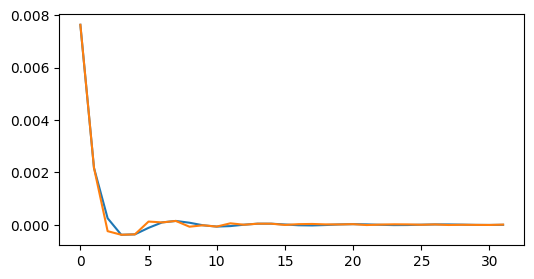

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(z0)
ax.plot(-get_z0(pars))

(101, 1000)


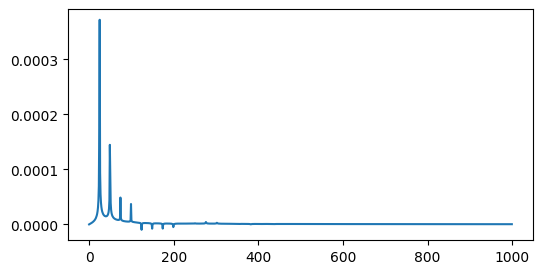

In [44]:
# print(gt_freq_resp.shape)
grid_idx = 22
gt_freq_resp_grid = inverse_STL(K, gt_freq_resp, get_length(pars))
print(gt_freq_resp_grid.shape)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(gt_freq_resp_grid[grid_idx])

(101, 1000)


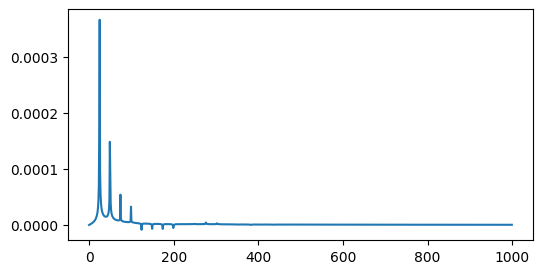

In [45]:
lambdas = string_eigenvalues(n_modes, length=get_length(pars))
b, a = tf_initial_conditions_continuous_2(
    D=string_params.bending_stiffness,
    density=string_params.density,
    lambda_mu=lambda_mu,
    d1=get_d1(pars),
    d3=get_d3(pars),
    Ts0=get_Ts0(pars),
)
b = b * get_z0(pars)
pred_freq_response = jnp.abs(tf_freqs(b, a, s))

pred_freq_response_grid = inverse_STL(K, pred_freq_response, get_length(pars))
print(pred_freq_response_grid.shape)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(pred_freq_response_grid[grid_idx])

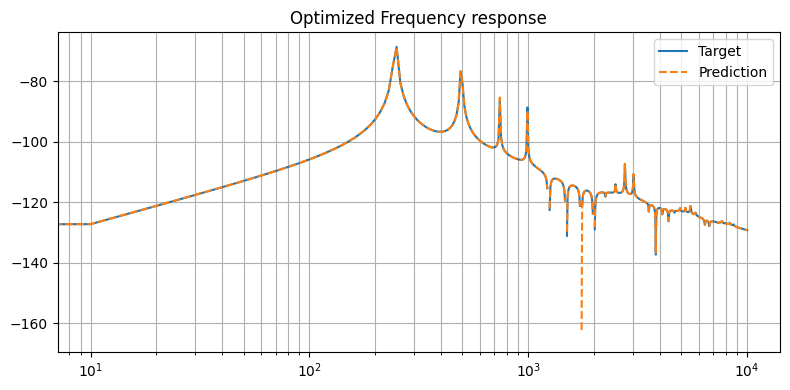

In [46]:
def to_db(x):
    return 20 * jnp.log10(x)


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.set_title("Optimized Frequency response")
ax.semilogx(
    omegas,
    to_db(gt_freq_resp_grid[grid_idx]),
    label="Target",
)
ax.semilogx(
    omegas,
    to_db(pred_freq_response_grid[grid_idx]),
    label="Prediction",
    linestyle="--",
)
ax.grid(which="both")
_ = ax.legend()
fig.tight_layout()

## Fitting to real data

In [49]:
import soundfile as sf
from scipy.signal import butter, lfilter, resample
from scipy.signal import czt, czt_points

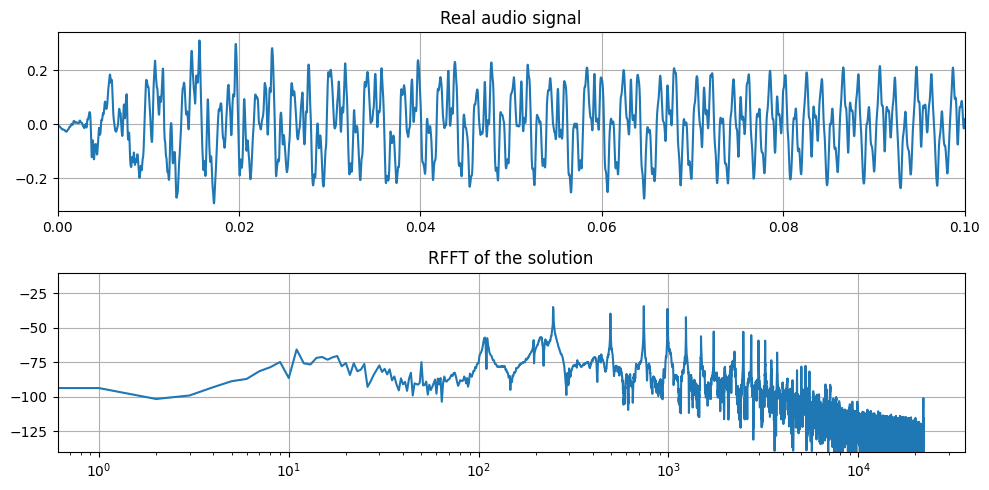

In [50]:
stiff_string_real, file_sr = sf.read(
    "audio/117674__kyster__b-open-string.wav",
)

duration = 1.0
offset = int(0.08 * file_sr)
stop = int(1 * file_sr)
# ensure the audio has exactly the same length
stiff_string_real = stiff_string_real[offset : offset + stop, 0]

# low pass filter the audio
# b, a = butter(N=4, Wn=10000, btype="low", fs=file_sr)
# stiff_string_real = lfilter(b, a, stiff_string_real)

# get the rfft of the real audio
u_stiff_string_rfft = np.fft.rfft(stiff_string_real, norm="forward")

t = np.linspace(0, duration, len(stiff_string_real))
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].set_title(f"Real audio signal")
ax[0].plot(t, stiff_string_real)
ax[0].set_xlim(0, 0.1)
ax[0].grid("both")
ax[1].set_title("RFFT of the solution")
ax[1].semilogx(to_db(np.abs(u_stiff_string_rfft)))
ax[1].grid("both")
ax[1].set_ylim(-140, -10)
fig.tight_layout()

In [51]:
rng = np.random.default_rng(654)
pars = {
    # "rho": jax.random.uniform(jax.random.PRNGKey(0), shape=(1,)).item(),
    # "A": string_params.A,
    "density": string_params.density / RANGE_DENSITY,
    "bending_stiffness": string_params.bending_stiffness / RANGE_BENDING_STIFFNESS,
    # "density": string_params.density / RANGE_DENSITY,
    # "bending_stiffness": string_params.bending_stiffness / RANGE_BENDING_STIFFNESS,
    "d1": string_params.d1 / RANGE_D1 * 2,
    "d3": string_params.d3 / RANGE_D3 * 2,
    "Ts0": string_params.Ts0 / RANGE_TS0 * 0.8,
    "length": string_params.length / RANGE_LENGTH,
    "z0": rng.normal(size=(n_modes, 1)).astype(np.float32),
}


def get_z0(params):
    return params["z0"]

(5000,)
(5000,)


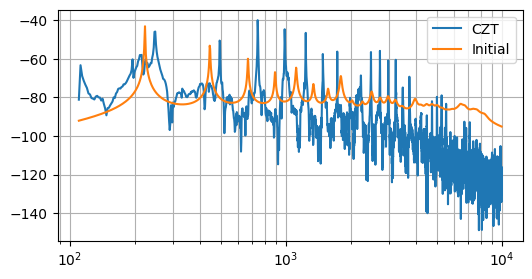

In [54]:
omegas = np.linspace(110, 10_000, 5000)
s = 2j * np.pi * omegas
domegas = omegas[1] - omegas[0]
domegas_rad = (domegas / file_sr) * 2 * np.pi

lambdas = string_eigenvalues(n_modes, length=get_length(pars))
b, a = tf_initial_conditions_continuous_2(
    D=string_params.bending_stiffness,
    density=string_params.density,
    lambda_mu=lambda_mu,
    d1=get_d1(pars),
    d3=get_d3(pars),
    Ts0=get_Ts0(pars),
)
b = b * get_z0(pars)
pred_freq_response = jnp.abs(tf_freqs(b, a, s))
pred_freq_response_grid = inverse_STL(K, pred_freq_response, get_length(pars))

u_stiff_string_rfft = np.fft.rfft(stiff_string_real)
fft_freqs = np.fft.rfftfreq(len(stiff_string_real), 1 / file_sr)
# u_stiff_string_rfft = resample(u_stiff_string_rfft, len(omegas))


# print(domegas_rad * len(omegas))
a = np.exp(s[0] / file_sr)  # but this is 1 if omegas[0]=0
X_czt = czt(
    stiff_string_real,
    m=len(omegas),
    w=np.exp(-1j * domegas_rad),
    a=a,
)
print(X_czt.shape)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# ax.semilogx(
#     fft_freqs,
#     to_db(np.abs(u_stiff_string_rfft) / np.max(np.abs(u_stiff_string_rfft))),
#     label="FFT",
# )
normalised_gt = np.abs(X_czt) / np.max(np.abs(X_czt)) * 0.01

ax.semilogx(
    omegas,
    to_db(normalised_gt),
    label="CZT",
)
ax.semilogx(
    omegas,
    to_db(pred_freq_response.mean(axis=0)),
    label="Initial",
)
ax.grid(which="both")
_ = ax.legend()

print(normalised_gt.shape)

In [55]:
iterations = 10_000
optimiser = optax.adabelief(1e-3)
state = optimiser.init(pars)


@jax.jit
def train_step(pars, state):
    def loss_fn(pars):
        lambda_mu = string_eigenvalues(n_modes, length=get_length(pars))

        b, a = tf_initial_conditions_continuous_2(
            D=string_params.bending_stiffness,
            density=string_params.density,
            lambda_mu=lambda_mu,
            d1=get_d1(pars),
            d3=get_d3(pars),
            Ts0=get_Ts0(pars),
        )

        # apply the initial condition
        # b = b * z0[:, None]
        b = b * get_z0(pars)

        # here we take the mean of the frequency response
        # and normalise it
        pred_freq_response = jnp.abs(tf_freqs(b, a, s)).mean(axis=0)
        normalised_pred_freq_response = pred_freq_response

        loss = log_mag_loss(normalised_pred_freq_response, normalised_gt)
        spec_loss = spectral_convergence_loss(
            normalised_pred_freq_response, normalised_gt
        )
        # ot_loss = jnp.mean(
        #     spectral_wasserstein(
        #         log_mag(normalised_gt),
        #         log_mag(normalised_pred_freq_response),
        #         is_mag=True,
        #     )
        # )

        return loss + spec_loss  # + ot_loss # * 0.1

    loss, grads = jax.value_and_grad(loss_fn)(pars)

    updates, state = optimiser.update(grads, state, pars)
    pars = optax.apply_updates(pars, updates)
    return pars, state, loss


# We'll create a single Rich Progress instance with columns:
progress = Progress(
    TextColumn("[bold blue]{task.description}"),  # e.g. "Training"
    BarColumn(),
    TaskProgressColumn(),  # shows "n/N"
    TimeRemainingColumn(),
    refresh_per_second=20,
)
task_id = progress.add_task("Training", total=iterations)

# Start the progress context
with Live(refresh_per_second=20) as live:
    for i in range(iterations):
        pars, state, loss = train_step(pars, state)
        progress.update(task_id, advance=1)

        # Build multiline stats
        # (Rich supports newlines, colors, etc.)
        stats_str = (
            f"[bold cyan]Loss[/bold cyan]:    {loss:.6f}\n"
            f"rho:    {get_density(pars):.2e} / {string_params.density:.2e}\n"
            f"bend:   {get_bending_stiffness(pars):.2e} / {string_params.bending_stiffness:.2e}\n"
            f"d1:     {get_d1(pars):.2e} / {string_params.d1:.2e}\n"
            f"d3:     {get_d3(pars):.2e} / {string_params.d3:.2e}\n"
            f"Ts0:    {get_Ts0(pars):.2f} / {string_params.Ts0:.2f}\n"
            f"len:    {get_length(pars):.2f} / {string_params.length:.2f}"
        )

        # Create a small panel for the stats (expand=False keeps it tight)
        stats_panel = Panel(stats_str, title="String Parameters", expand=False)

        # Combine progress + stats panel into a single renderable Group
        layout = Group(progress, stats_panel)

        # Update the live display in-place
        live.update(layout)

Output()

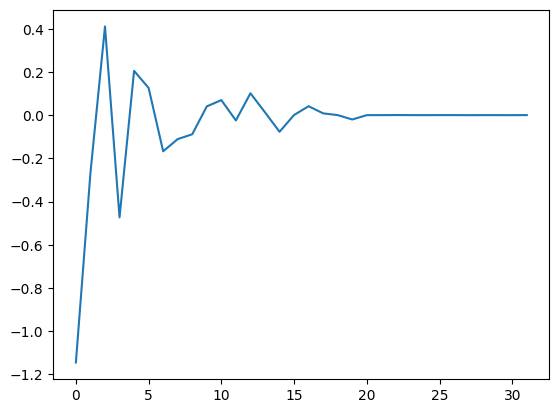

In [56]:
plt.plot(get_z0(pars))

In [59]:
lambda_mu = string_eigenvalues(n_modes, length=get_length(pars))

b, a = tf_initial_conditions_continuous_2(
    D=string_params.bending_stiffness,
    density=string_params.density,
    lambda_mu=lambda_mu,
    d1=get_d1(pars),
    d3=get_d3(pars),
    Ts0=get_Ts0(pars),
)

# apply the initial condition
b = b * get_z0(pars) * 10
pred_freq_response = jnp.abs(tf_freqs(b, a, s)).mean(axis=0)

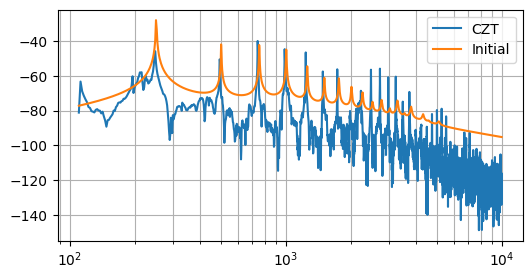

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.semilogx(
    omegas,
    to_db(normalised_gt),
    label="CZT",
)
ax.semilogx(
    omegas,
    to_db(pred_freq_response),
    label="Initial",
)
ax.grid(which="both")
_ = ax.legend()